In [1]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import style

%matplotlib notebook


# data preprocessing

# filenames=['DS0003','DS0006','DS0009','DS0012','DS0015','DS0017','DS0019','DS0021', \
#            'DS0024','DS0026','DS0028','DS0030','DS0032','DS0034']

filenames=['DS0003','DS0006','DS0009','DS0012','DS0015','DS0017']
cohorts=np.arange(1,7).astype(str).tolist()

data = {}
data_size=0
fpath='C:\\Users\\tolut\\Box Sync\\Documents\\PythonScripts\\dataIncubator\\ICPSR_23380\\'
for index, file in enumerate(filenames):
    fname = fpath+file+'\\23380-'+file[2:]+'-Data.tsv'
    temp_pd=pd.read_csv(fname,sep='\t',na_values=np.nan,dtype=str)
    temp_pd['cohort']=cohorts[index]
    data[cohorts[index]]=temp_pd
    data_size+=os.stat(fname).st_size

    
data_size=data_size/1e6

columnNames={}
for c in cohorts:
    columnNames[c]= data[c].columns

#unify column names
for index, c in enumerate(cohorts):
    prefix1='C'+ c
    prefix2='R'+ c
    prefix3='P'+ c
    st=len(prefix1)
    temp_columnNames=[ x.replace(c,'_')  if (x.startswith(prefix1)|x.startswith(prefix2) |x.startswith(prefix3)) \
                      else x  for x in data[c].columns]
    data[c].columns=temp_columnNames

#accounting for changes in column names
# change the PLREG column name in cohort 6
data['6'].rename(columns={'P_PLREG':'PLREG'},inplace=True)
data['2'].rename(columns={'C_DEP_YR':'C_DEP2YR'},inplace=True)
data['2'].rename(columns={'R_DEP_YR':'R_DEP2YR'},inplace=True)
data['1'].rename(columns={'C_SMK_00':'C_SMK100'},inplace=True)
data['1'].rename(columns={'R_SMK_00':'R_SMK100'},inplace=True)
data['1'].rename(columns={'C_WLK_BK':'C_WLK1BK'},inplace=True)
data['1'].rename(columns={'R_WLK_BK':'R_WLK1BK'},inplace=True)
data['3'].rename(columns={'C_CASE_ID':'CASE_ID'},inplace=True)
data['4'].rename(columns={'SFLAG':'STATUS'},inplace=True)
data['5'].rename(columns={'SFLAG':'STATUS'},inplace=True)
data['6'].rename(columns={'SFLAG':'STATUS'},inplace=True)
# data['7'].rename(columns={'SFLAG':'STATUS'},inplace=True)
# data['7'].rename(columns={'R_PLREGCDE':'PLREG'},inplace=True)
# data['8'].rename(columns={'SFLAG':'STATUS'},inplace=True)
# data['8'].rename(columns={'R_PLREGCDE':'PLREG'},inplace=True)

# combine
com_cols=set(data['1'])
for c in cohorts:
    com_cols=com_cols & set(data[c])

com_cols=list(com_cols)
    
c_data=data['1'][com_cols]
for c in cohorts[1:]:
    c_data=c_data.append(data[c][com_cols])

# deal with missing values and tranform ordinal variables
c_data.replace(r'\s+', np.nan, regex=True,inplace=True)

In [2]:
# data clean up and transformation (1)
d_dict=pd.ExcelFile('insurance.xlsx').parse('Sheet1') # arbitrary scale created for data columns
cat_dict=dict(zip(d_dict.feature,d_dict.Category))
longName_dict=dict(zip(d_dict.feature,d_dict['long name']))
Categories=list(set(cat_dict.values()))

#create transformation dictionary
trans_dict=defaultdict(dict)
for feature in d_dict.feature:
    temp_allowed = d_dict.loc[d_dict.feature==feature,'allowed']
    temp_trans=d_dict.loc[d_dict.feature==feature,'transformed']
    if not(pd.isnull(temp_trans.values) | pd.isnull(temp_allowed.values)):
        keys=temp_allowed.values[0].split(',')
        values=list(map(int,temp_trans.values[0].split(',')))
        trans_dict[feature]=defaultdict(lambda: np.nan,zip(keys,values))
        
t_data=c_data.copy() # transformed data
t_data.replace(to_replace=trans_dict,inplace=True)

#group features into classes
Computables=['Health PerceptionA','Chronic ConditionsA','Physical HealthA','Lifestyle ChoicesA','Emotional HealthA', \
            'Health PerceptionB','Chronic ConditionsB','Physical HealthB','Lifestyle ChoicesB','Emotional HealthB']
Compute_dict=defaultdict(list)
for feature in  t_data.columns:
    Compute_dict[cat_dict[feature]].append(feature)
    
#append new grouping features to table
for feature in Computables:
    temp_cols=Compute_dict.get(feature)
    t_data[feature]=t_data[temp_cols].mean(axis=1)

In [3]:
#create list of predictor features and output targets
pfeatures=['PLREG','cohort']
targets=[] # target features

for c in c_data.columns:
    if c.startswith('C_'):
        pfeatures.append(c)
    if c.startswith('R_'):
        targets.append(c)


# remove unwanted features
notWanted=['C_WHOCMP','C_SRVDSP','C_RNDNUM','C_PCTCMP','R_SVLANG','SAMPLED', \
           'R_WHOCMP','R_SRVDSP','R_RNDNUM','R_PCTCMP','COHORT']

pfeatures=list(set(pfeatures)-set(notWanted))
targets=list(set(targets)-set(notWanted))

#remove invalid data and rows/columns with too many NaNs
c_data2=c_data.copy()
c_data2.drop(c_data2[c_data2.STATUS=='3'].index,inplace=True) #invalid

# surveys less than 80% complete
c_data2.drop(c_data2[c_data2.R_SRVDSP!='M10'].index,inplace=True) 
c_data2.drop(c_data2[c_data2.C_SRVDSP!='M10'].index,inplace=True) 

X_data=c_data2[pfeatures]
y_data=c_data2[targets]


X_data=X_data.applymap(lambda x: int(x) if (isinstance(x,str)) else np.nan)
y_data=y_data.applymap(lambda x: int(x) if (isinstance(x,str)) else np.nan)


In [4]:
# data clean up and transformation (2)
# from statistics import mode
#replace missing values with median

def custom_replace(x):
    md=np.nanmedian(x)
    return x.fillna(value=md)
    
X_data=X_data.apply(custom_replace, axis=0)
y_data=y_data.apply(custom_replace, axis=0)
# #convert categorical variables to continuous using one-hot encoding
X_data=pd.get_dummies(X_data,columns=pfeatures)



In [5]:
# machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE,MDS
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN

#use only a subset of the data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data, y_data,\
        test_size=0.25,random_state=0)
# X_data2=X_test2.copy()
# y_data2=y_test2.copy()

X_data2=X_data.copy()
y_data2=y_data.copy()

X_train, X_test, y_train, y_test = train_test_split(X_data2, y_data2.R_AMI,\
        random_state=0)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
#nearest neighbor classifier
clf_knn = KNeighborsClassifier(n_neighbors = 10)
clf_knn.fit(X_train_scaled, y_train)
clf_knn.score(X_train_scaled, y_train)
clf_knn.score(X_test_scaled, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

0.90714647744551447

0.90483429613864397

In [7]:
# logistic regression
clf_log = LogisticRegression().fit(X_train_scaled, y_train)
clf_log.score(X_train_scaled, y_train)
clf_log.score(X_test_scaled, y_test)

0.94343639128231116

0.9364548494983278

In [8]:
# support vector machines
clf_svm = SVC(kernel = 'rbf', gamma = 1,
                 C = 100).fit(X_train_scaled, y_train)
clf_svm.score(X_train_scaled, y_train)
clf_svm.score(X_test_scaled, y_test)

1.0

0.89753724536333235

In [22]:
# neural networks
clf_nn = MLPClassifier(hidden_layer_sizes = [50, 50,50], alpha = 90.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)
clf_nn.score(X_train_scaled, y_train)
clf_nn.score(X_test_scaled, y_test)

0.9486061834769387

0.93675889328063244

<IPython.core.display.Javascript object>


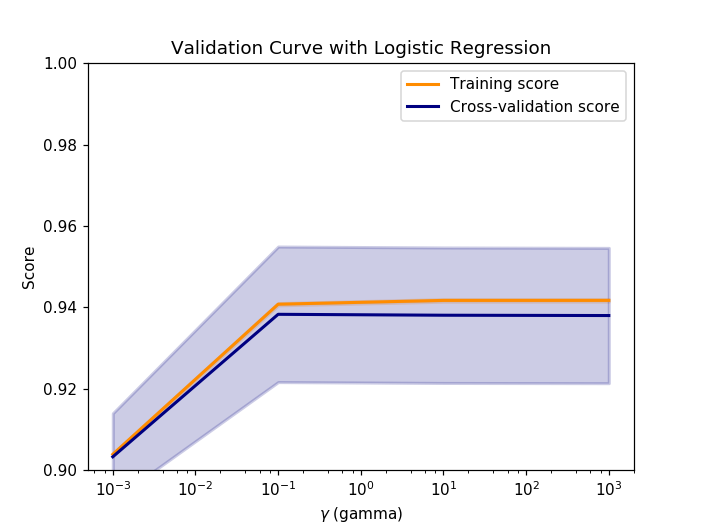

<IPython.core.display.Javascript object>


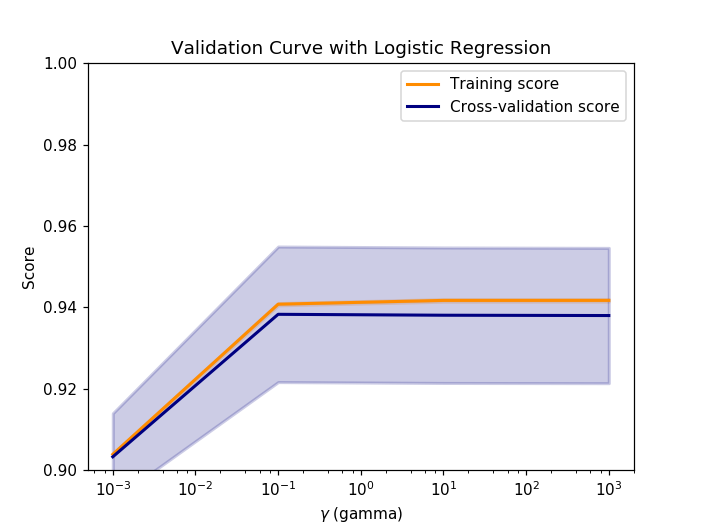

(0.9, 1.0)

In [35]:
#validation curve


param_range = np.logspace(-3, 3, 4)
train_scores, test_scores = validation_curve(LogisticRegression(), X_data2, y_data2.R_AMI,
                                            param_name='C',
                                            param_range=param_range, cv=100)
plt.figure()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with Logistic Regression')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.ylim(0.9, 1.0)
lw = 2

plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.show()

In [ ]:
# dimensionality reduction analyses
from adspy_shared_utilities import plot_labelled_scatter

X_normalized = StandardScaler().fit(X_data2).transform(X_data2) 
pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)
plot_labelled_scatter(X_pca, y_data2.R_AMI, ['yes', 'no'])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('demo1');


In [ ]:
#multi dimensional scaling (MDS) 

mds = MDS(n_components = 2)

X_mds = mds.fit_transform(X_normalized)

plot_labelled_scatter(X_mds, y_data.R_DIABET, ['yes', 'no'])
plt.xlabel('First MDS feature')
plt.ylabel('Second MDS feature')
plt.title('demo');

In [ ]:
# t-SNE
tsne = TSNE(random_state = 0)

X_tsne = tsne.fit_transform(X_normalized)

plot_labelled_scatter(X_tsne, y_data.R_DIABET, 
    ['yes', 'no'])
plt.xlabel('First t-SNE feature')
plt.ylabel('Second t-SNE feature')

In [ ]:
# clustering
dbscan = DBSCAN(eps = 2, min_samples = 2)

cls = dbscan.fit_predict(X_data2)
plot_labelled_scatter(X_data2, cls + 1, 
        ['Noise', 'Cluster 0', 'Cluster 1', 'Cluster 2'])

In [7]:
# exploratory data analyses
#transformation dictionaries
rdict={}
rdict['1']='Region I - Boston'
rdict['2']='Region II - New York'
rdict['3']='Region III - Philadelphia'
rdict['4']='Region IV - Atlanta'
rdict['5']='Region V - Chicago'
rdict['6']='Region VI - Dallas'
rdict['7']='Region VII - Kansas City'
rdict['8']='Region VIII - Denver'
rdict['9']='Region IX - San Francisco'
rdict['10']='Region X - Seattle'

racedict=dict(zip(['1','2','3'],['White','Black','Other']))
gendict=dict(zip(['1','2'],['Male','Female']))
agedict=dict(zip(['1','2','3'],['<65','65-74','>74']))
mrdict=dict(zip(['1','2'],['Married','Non-Married']))
educdict=dict(zip(['1','2','3'],['< high school or GED','high school or GED','> high school or GED']))

replace_dict={'PLREG':rdict,'C_RACE':racedict,'C_GENDER':gendict,'C_AGEGRP':agedict, \
        'C_MRSTAT':mrdict,'C_EDUC':educdict}

t_data.replace(to_replace=replace_dict,inplace=True)

t_data2=t_data.copy()
#remove incomplete rows
t_data2.drop(t_data2[t_data2.STATUS=='3'].index,inplace=True) #invalid
# surveys less than 80% complete
t_data2.drop(t_data2[t_data2.R_SRVDSP!='M10'].index,inplace=True) 
t_data2.drop(t_data2[t_data2.C_SRVDSP!='M10'].index,inplace=True) 

special=['cohort','PLREG','C_AGEGRP','C_RACE','C_GENDER','C_MRSTAT','C_EDUC','Health PerceptionA','Chronic ConditionsA',\
          'Physical HealthA','Lifestyle ChoicesA','Emotional HealthA', \
            'Health PerceptionB','Chronic ConditionsB','Physical HealthB','Lifestyle ChoicesB','Emotional HealthB']
sp_data=pd.DataFrame()
sp_data=sp_data.append(t_data2[special])

change_labels=['Health Perception','Physical Health','Emotional Health','Chronic Conditions']

for cl in change_labels:
    temp_cl1=cl+'A'
    temp_cl2=cl+'B'
#     sp_data[cl]=(c_data[temp_cl2]-c_data[temp_cl1])/c_data[temp_cl1]*100
    sp_data[cl]=sp_data[temp_cl2]/sp_data[temp_cl1]*100

# sp_data.groupby('PLREG').median()
map_data=sp_data.groupby('PLREG').median()


In [ ]:
map_data

In [17]:
#visualization I
import warnings; warnings.simplefilter('ignore')
from bokeh.io import show,output_notebook
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from collections import defaultdict
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure
from bokeh.sampledata.us_states import data as states

#remove non mainland states
# del states["HI"]
# del states["AK"]

palette.extend(palette[0:4])
region_dict=defaultdict(list)
rate_dict={}
color_dict={}
region_dict['Region I - Boston']=['CT','ME','MA','NH','RI','VT']
region_dict['Region II - New York']=['NY','NJ','PR','VI']
region_dict['Region III - Philadelphia']=['DE','DC','MD','PA','VA','WV']
region_dict['Region IV - Atlanta']=['AL','FL','GA','KY','MS','NC','SC','TN']
region_dict['Region V - Chicago']=['IL','IN','MI','MN','OH','WI']
region_dict['Region VI - Dallas']=['AR','LA','NM','OK','TX']
region_dict['Region VII - Kansas City']=['IA','KS','MO','NE']
region_dict['Region VIII - Denver']=['CO','MT','ND','SD','UT','WY']
region_dict['Region IX - San Francisco']=['AZ','CA','GU','HI','NV']
region_dict['Region X - Seattle']=['AK','ID','OR','WA']

for index, key in enumerate(region_dict.keys()):
    rate_dict[key]=index
    color_dict[key]=palette[index]

state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]
fill_colors=[]
region_names=[]
region_rates=[]
state_names=[]
# health outcome indices
PHA=[]
EHA=[]
HP=[]
PHA_f=[]
EHA_f=[]
HP_f=[]

for x in states.keys():
    for key, value in region_dict.items():
        if x in value:
            region_names.append(key)
            region_rates.append(rate_dict[key])
            fill_colors.append(color_dict[key])
            state_names.append(states[x]['name'])
            PHA.append(np.round(map_data.loc[key,'Physical HealthA'],2))
            EHA.append(np.round(map_data.loc[key,'Emotional HealthA'],2))
            HP.append(np.round(map_data.loc[key,'Health PerceptionA'],2))
            PHA_f.append(np.round(map_data.loc[key,'Physical Health'],2))
            EHA_f.append(np.round(map_data.loc[key,'Emotional Health'],2))
            HP_f.append(np.round(map_data.loc[key,'Health Perception'],2))
             
source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    name=region_names,
    sname=state_names,
    rate=region_rates,
    PHA_=PHA,
    EHA_=EHA,
    HP_=HP,
    PHA_f_=PHA_f,
    EHA_f_=EHA_f,
    HP_f_=HP_f
    
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="Health Outcomes survey, 1998-2014", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,
    plot_width=1100,plot_height=800
)
p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color=fill_colors,
          fill_alpha=0.7, line_color='white', line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Region", "@name"),
    ("State", "@sname"),
    ("Physical Health", "@PHA_"),
    ("Emotional Health", "@EHA_"),
    ("Health Perception", "@HP_"),
    ("Physical Health Improvement", "@PHA_f_"),
    ("Emotional Health Improvement", "@EHA_f_"),
    ("Health Perception Improvement", "@HP_f_"),
    ("(Long, Lat)", "($x, $y)"),
]

# output_notebook()
show(p)


GlyphRenderer(id='1d7e2deb-6338-4187-89a6-b9f55b2b158b', ...)

Loading BokehJS ...

In [12]:
from bokeh.resources import CDN
from bokeh.embed import file_html
html = file_html(p, CDN, "HealthMap")

In [14]:
Html_file= open("HealthMap.html","w")
Html_file.write(html)
Html_file.close()

192131

In [6]:
from bokeh.charts import Bar, output_file, show
from bokeh.sampledata.autompg import autompg as df
from bokeh.models import Range1d, ColumnDataSource

# sp_data.head()
vis2=['Health PerceptionA','Physical HealthA','Emotional HealthA', \
            'Health Perception','Physical Health','Emotional Health']

VARS=['C_AGEGRP','C_RACE','C_GENDER','C_MRSTAT','C_EDUC']


var='C_MRSTAT'
plot_pd=pd.melt(sp_data,id_vars=['C_AGEGRP','C_RACE','C_GENDER','C_MRSTAT','C_EDUC'], \
       value_vars=vis2,var_name='plot_var',value_name='plot_val') 


source=ColumnDataSource(data=plot_pd)
p = Bar(source=source, label='plot_var', values='plot_val', agg='median', group=var,
        title="demo plot", legend='top_right')

p.xaxis.axis_label=None
# p.yaxis.axis_label_text_font_size=20
p.yaxis.minor_tick_out=None
p.yaxis.major_tick_out=None
p.y_range=Range1d(65,100)
p.yaxis.axis_label='Health Index'
p.ygrid.grid_line_color=None
p.xgrid.grid_line_color=None
p.outline_line_width=1
p.outline_line_color='black'

output_file("demobar.html")

show(p)

NameError: name 'sp_data' is not defined

In [ ]:
ColumnDataSource?

In [73]:
df.head()
vis2

,mpg,cyl,displ,hp,weight,accel,yr,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


['Health PerceptionA',
 'Physical HealthA',
 'Emotional HealthA',
 'Health Perception',
 'Physical Health',
 'Emotional Health']

In [72]:
# # 'PLREG','C_AGEGRP','C_RACE','C_GENDER','C_MRSTAT','C_EDUC'


from bokeh.charts import Bar

# vis_data=sp_data[vis2]

# p=Bar(vis_data, label=var)

# labels=vis_data.index.unique()
# pos=list(range(6))
# width=0.2
# colors=['blue','green','red','cyan'][0:len(labels)]
# xyvalues=vis_data

# bar = Bar(xyvalues, vis2, title="demographic factors",
#         ylabel='health index')

# output_file("demo_bar.html")
# show(bar)



# for ind, label in enumerate(labels):
#     ax.bar([p + width*ind for p in pos],vis_data.loc[label,],width,alpha=0.5,color=colors[ind],label=label)
# ax.legend(frameon=False)
# ax.set_ylim(55,100)
# _=ax.set_ylabel('Health index')
# _=plt.xticks(range(6),vis2,rotation=10)
# plt.subplots_adjust(wspace=0.35)
# plt.tight_layout()

In [13]:
#save data for app
sp_data.to_pickle(r'C:\Users\tolut\Box Sync\Documents\PythonScripts\dataIncubator\HOS_demo\mydata') 


In [2]:
import pandas as pd
sp_data2 = pd.read_pickle(r'C:\Users\tolut\Box Sync\Documents\PythonScripts\dataIncubator\HOS_demo\mydata')
def make_plot(sp_data,current_factor):
    labels=['Health PerceptionA','Physical HealthA','Emotional HealthA', \
            'Health Perception','Physical Health','Emotional Health']
    plot_pd=pd.melt(sp_data,id_vars=['C_AGEGRP','C_RACE','C_GENDER','C_MRSTAT','C_EDUC'], \
       value_vars=labels,var_name='plot_var',value_name='plot_val')

    p = Bar(plot_pd, label='plot_var', values='plot_val', agg='median', group=current_factor,
            title="demo plot", legend='top_right')
    p.xaxis.axis_label=None
    p.yaxis.minor_tick_out=None
    p.yaxis.major_tick_out=None
    p.y_range=Range1d(30,100)
    p.yaxis.axis_label='Health Index'
    p.ygrid.grid_line_color=None
    p.xgrid.grid_line_color=None
    p.outline_line_width=1
    p.outline_line_color='black'

    return p
make_plot(sp_data,current_factor)

In [5]:
sp_data2.shape
%pwd

(13154, 21)

'C:\\Users\\tolut\\Box Sync\\Documents\\PythonScripts\\dataIncubator'

In [ ]:
!bokeh serve --port 5006 --show  HOS_demo/

<IPython.core.display.Javascript object>


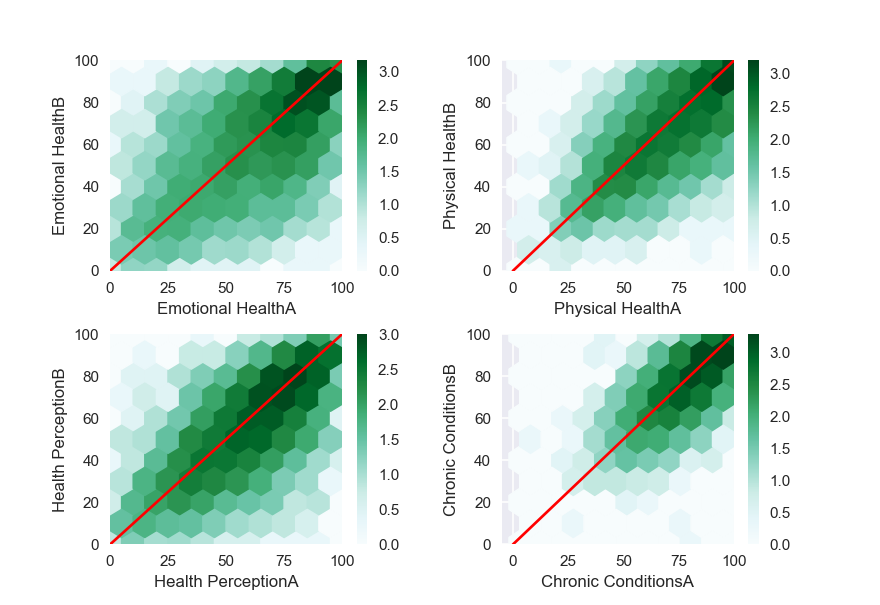

<IPython.core.display.Javascript object>


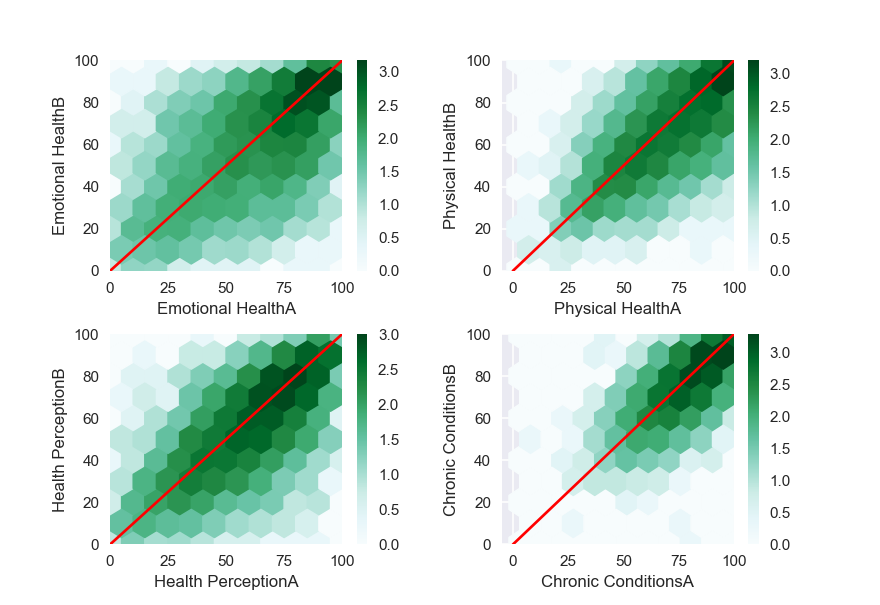

In [72]:
#visualization II
# racedict=dict(zip(['1','2','3'],['White','Black','Other']))
# gendict=dict(zip(['1','2'],['Male','Female']))
# agedict=dict(zip(['1','2','3'],['<65','65-74','>74']))
# mrdict=dict(zip(['1','2'],['Married','Non-Married']))
# educdict=dict(zip(['1','2','3'],['< high school or GED','high school or GED','> high school or GED']))

# color_dict={'1': 'red','2':'blue','3':'green','4':'cyan','5':'magenta','6':'yellow','7':'black','8':'rosybrown','9':'seagreen',
#            '10':'chocolate'}

# color_dict={'< high school or GED': 'red','high school or GED': 'blue','> high school or GED':'green'}
# temp_color=sp_data['C_EDUC'].apply(lambda x: color_dict.get(x,'white'))
# plt.figure()
# plt.scatter(sp_data['Health PerceptionA'],sp_data['Physical HealthA'],s=1,c=temp_color)

plt.figure()
gdsize=10
ax1=plt.subplot(221)
sp_data.plot(kind='hexbin', x='Emotional HealthA', y='Emotional HealthB', gridsize=gdsize,ax=ax1,bins='log')
ax1.plot([0,100],[0,100],color='red')


ax2=plt.subplot(222)
sp_data.plot(kind='hexbin', x='Physical HealthA', y='Physical HealthB', gridsize=gdsize,ax=ax2,bins='log')
ax2.plot([0,100],[0,100],color='red')

ax3=plt.subplot(223)
sp_data.plot(kind='hexbin', x='Health PerceptionA', y='Health PerceptionB', gridsize=gdsize,ax=ax3,bins='log')
ax3.plot([0,100],[0,100],color='red')
# ax1.set_xlim(50,100)
# ax1.set_ylim(50,100)

ax4=plt.subplot(224)
sp_data.plot(kind='hexbin', x='Chronic ConditionsA', y='Chronic ConditionsB', gridsize=gdsize,ax=ax4,bins='log')
ax4.plot([0,100],[0,100],color='red')

plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9,hspace=0.3,wspace=0.35)


<IPython.core.display.Javascript object>


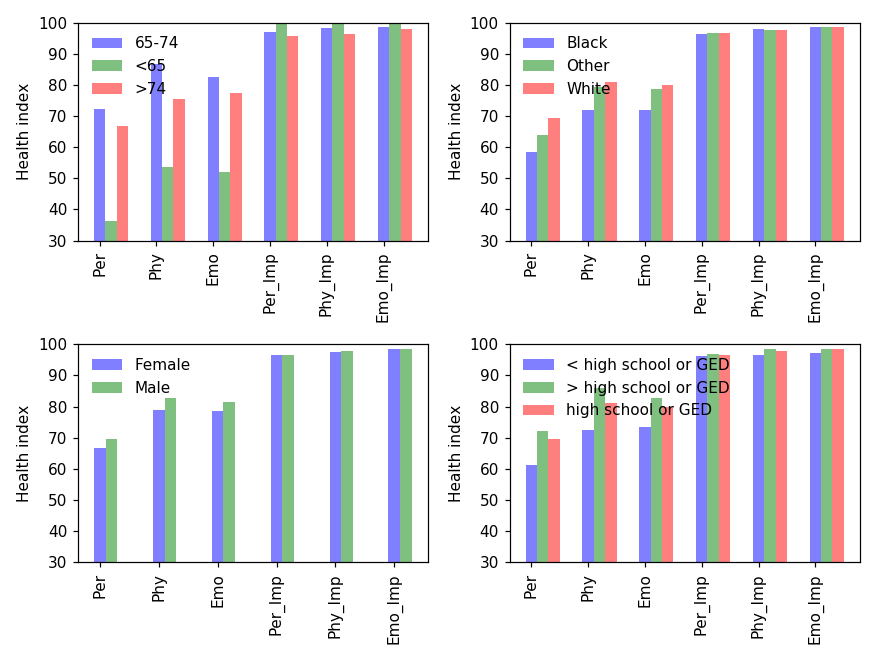

<IPython.core.display.Javascript object>


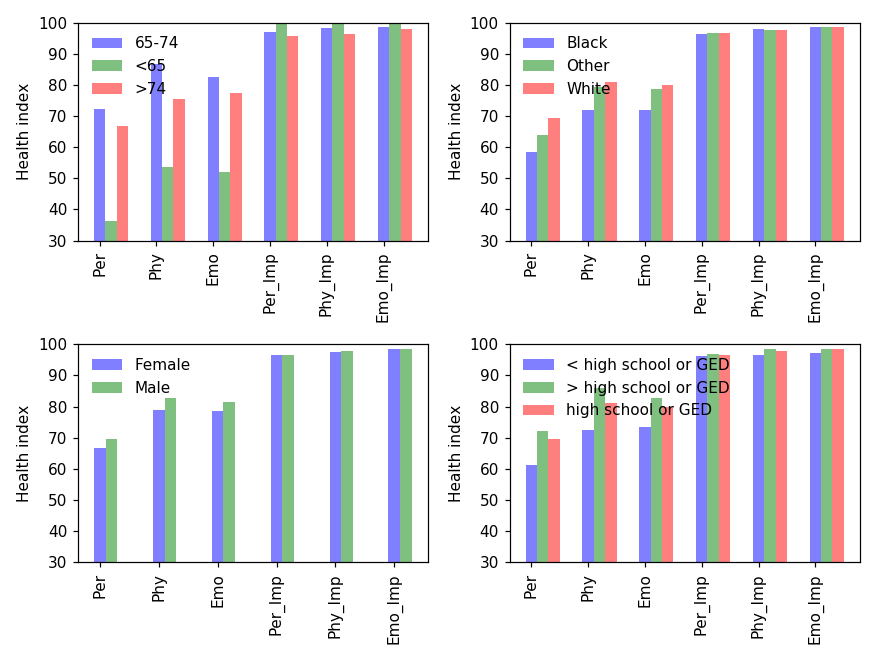

<Container object of 6 artists>

<Container object of 6 artists>

<Container object of 6 artists>

(30, 100)

<Container object of 6 artists>

<Container object of 6 artists>

<Container object of 6 artists>

(30, 100)

<Container object of 6 artists>

<Container object of 6 artists>

(30, 100)

<Container object of 6 artists>

<Container object of 6 artists>

<Container object of 6 artists>

(30, 100)

In [55]:
# 'PLREG','C_AGEGRP','C_RACE','C_GENDER','C_MRSTAT','C_EDUC'
vis2=['Health PerceptionA','Physical HealthA','Emotional HealthA', \
            'Health Perception','Physical Health','Emotional Health']

VARS=['C_AGEGRP','C_RACE','C_GENDER','C_EDUC']


plt.figure(figsize=(8,6))

for (index,var) in enumerate(VARS):
    ax=plt.subplot(2,2,index+1)
    vis_data=sp_data.groupby(var)[vis2].median()
    labels=vis_data.index.unique()
    pos=list(range(6))
    width=0.2
    colors=['blue','green','red','cyan'][0:len(labels)]
    for ind, label in enumerate(labels):
        ax.bar([p + width*ind for p in pos],vis_data.loc[label,],width,alpha=0.5,color=colors[ind],label=label)
    ax.legend(frameon=False)
    ax.set_ylim(30,100)
    _=ax.set_ylabel('Health index')
    _=plt.xticks(range(6),['Per','Phy','Emo','Per_Imp','Phy_Imp','Emo_Imp'],rotation=90)
plt.subplots_adjust(wspace=0.05,hspace=0.1)
plt.tight_layout()